In [1]:
# !pip install matplotlib wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Input,
    Embedding,
    Dot,
    Dense,
    Flatten
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
    EarlyStopping
)


from wordcloud import WordCloud
%matplotlib inline

2025-11-07 14:59:54.707040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 14:59:55.105826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 14:59:58.113274: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


# **Reading anime_list.csv**

In [3]:
import os

INPUT_DIR = os.path.join("..", "artifacts", "raw")  # ".." is root

In [4]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory= True, usecols = ["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### DATA PROCESSING

In [7]:
# Focus on active users
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating =min(rating_df["rating"])
max_rating =max(rating_df["rating"])
avg_rating =np.mean(rating_df["rating"])
print(f"Maximum rating = {max_rating}; Minimum rating = {min_rating}; average rating = {avg_rating}")

Maximum rating = 10; Minimum rating = 0; average rating = 4.122732695114736


In [10]:
# Minmax scaling

rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [11]:
# Check for data issues
print(f'# duplicated rows = {rating_df.duplicated().sum()}')
rating_df.isna().sum()

# duplicated rows = 0


user_id     0
anime_id    0
rating      0
dtype: int64

In [12]:
# Encoding user ID
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}

rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [13]:
n_users = len(user2user_encoded)
n_users

4203

In [14]:
# Encoding anime ID
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}

rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [15]:
n_animes = len(anime2anime_encoded)
n_animes

17149

In [16]:
# More randomness into the data >>> not row relationship
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)   #frac = 1 means shuffeling whole data

In [17]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [18]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [19]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size   #Since the whole data's already randomized across rows

X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

# Tensorflow takes only numpy arrays
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]
type(X_train_array)

list

In [20]:
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81], shape=(3245641,)),
 array([1377, 1216, 1239, ...,  861, 2402, 1262], shape=(3245641,))]

In [21]:
len(X_train)

3245641

### MODEL ARCHITECTURE

In [22]:
# The embedding model

def RecommenderNet():
    embedding_size = 128

    # Input layer "user"
    user = Input(name = "user", shape = [1])  
    user_embedding = Embedding(name = "user_embedding", input_dim = n_users, output_dim = embedding_size)(user)

    # Input layer "anime"
    anime = Input(name = "anime", shape = [1])  
    anime_embedding = Embedding(name = "anime_embedding", input_dim = n_animes, output_dim= embedding_size)(anime)

    # Dot layer >>> similarity between anime and user embedding
    x = Dot(name = "dot_product", normalize= True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)  # flatten layer

    # Dense layer >>> flatten from multi-dim to 1 dim 
    x = Dense(1, kernel_initializer= 'he_normal')(x)
    
    # Batch layer
    x = BatchNormalization()(x)

    # Activation layer
    x = Activation("sigmoid")(x)

    # Model layer
    model = Model(inputs= [user, anime], outputs = x)
    model.compile(loss = "binary_crossentropy", metrics = ['mae', 'mse'], optimizer = 'Adam')

    return model

In [23]:
model = RecommenderNet()
model.summary()

2025-11-07 15:00:04.981911: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [24]:
# Call back:  stop training if one model already lools bad in the middle
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Finding the best learning rate for the model
def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [25]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose = 0)
checkpoint_filepath = './weights.weights.h5'  # where the weights is stored

model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                                   save_weights_only= True, 
                                   monitor= 'val_loss', 
                                   mode = min,
                                   save_best_only = True
                                   )

early_stopping = EarlyStopping(patience = 3,   # Stop if no major improvement in 3 continuous epochs
                               monitor = "val_loss",
                               mode = min,
                               restore_best_weights = True
                               )

/home/damieniscreating/anime_suggestion/venv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:138: UserWarning: ModelCheckpoint mode '<built-in function min>' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, initial_value_threshold)
/home/damieniscreating/anime_suggestion/venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:77: UserWarning: EarlyStopping mode '<built-in function min>' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)


In [26]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping] 

In [27]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20, 
    verbose = 1, 
    validation_data = (X_test_array, y_test), 
    callbacks = my_callbacks 
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.7998 - mae: 0.3820 - mse: 0.1971 - val_loss: 0.7395 - val_mae: 0.3734 - val_mse: 0.1769 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.7963 - mae: 0.3807 - mse: 0.1957 - val_loss: 0.8097 - val_mae: 0.3872 - val_mse: 0.2023 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.7903 - mae: 0.3785 - mse: 0.1933 - val_loss: 0.8143 - val_mae: 0.3877 - val_mse: 0.2036 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.7818 - mae: 0.3752 - mse: 0.1899 - val_loss: 0.8097 - val_mae: 0.3865 - val_mse: 0.2018 - learning_rate: 3.4000e-05


During training, the loss pushes embeddings so that users and items that co-occur with high ratings have aligned vectors (large dot/cosine), and pairs that don’t co-occur (or have low ratings) are pushed apart. After training, items liked by similar users end up near each other; retrieving nearest neighbors by dot/cosine finds those co-preference clusters.

In [31]:
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81], shape=(3245641,)),
 array([1377, 1216, 1239, ...,  861, 2402, 1262], shape=(3245641,))]

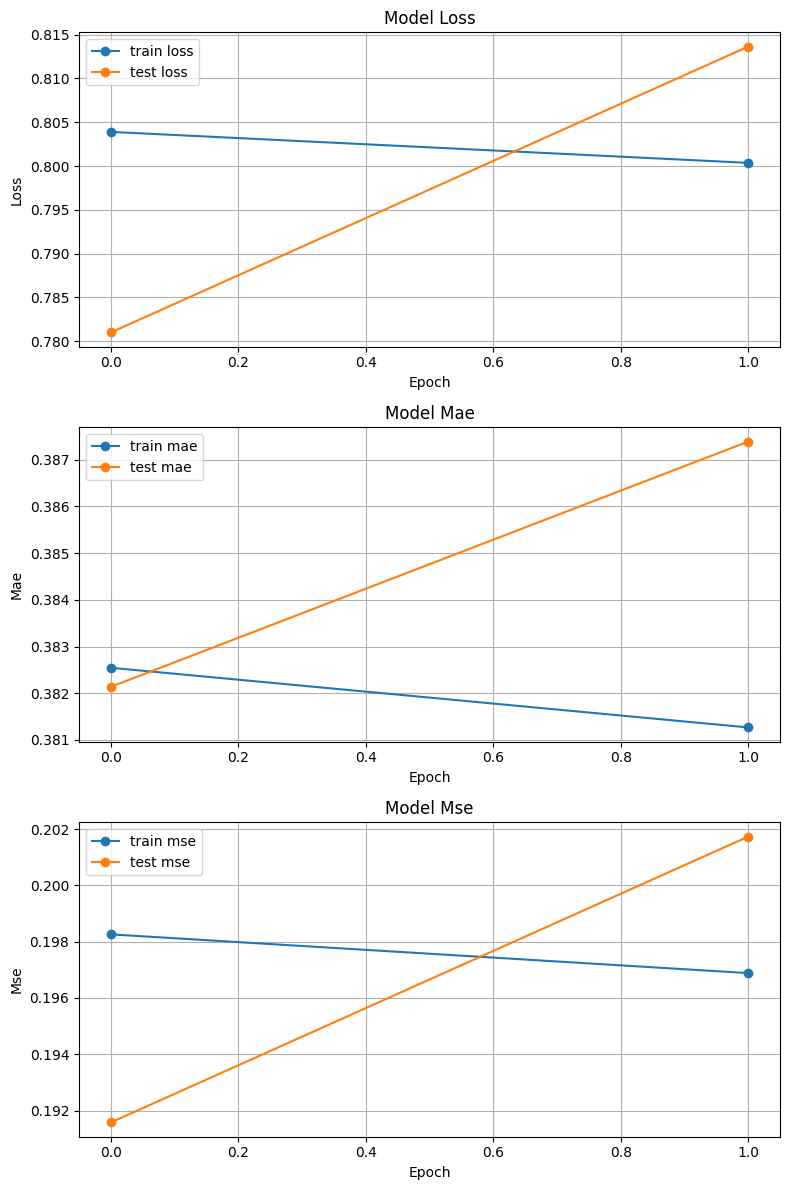

In [36]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Extract weights

def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0] 
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))   # 1-dim array
    return weights

In [29]:
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [30]:
# Each anime turned to a 128 vector, each of the vector gets their own weight
print(anime_weights.shape)
print(len(anime2anime_decoded))   

(17149, 128)
17149


In [46]:
rating_df

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353
...,...,...,...,...,...
3246636,7916,721,1.0,2005,955
3246637,7516,16067,0.0,1898,1398
3246638,12682,28171,0.8,3208,67
3246639,8387,33255,0.7,2114,1595


# **Anime Content Data**

### Reading anime.csv

In [31]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [32]:
df = df.replace("Unknown",np.nan)

In [34]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        # If there's missing english name
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [35]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df['eng_version'] = df['anime_id'].apply(lambda x: getAnimeName(x))

In [36]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [ ]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [37]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]
df.head(3)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


In [38]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [39]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [40]:
getAnimeFrame("Fullmetal Alchemist:Brotherhood", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


### anime_with_sypnosis.csv

In [41]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [42]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    
getSynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [43]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# **Content/Item Based Recommendation**

In [44]:
pd.set_option("max_colwidth", None)  # Show full string in a dataframe

In [45]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    # Should normalize the weights first --
    # If vectors are L2-normalized (unit length), the dot product equals cosine similarity (∈ [−1, 1]). Larger = more similar direction in the latent space.
    # If not normalized, the dot product mixes angle + vector length (popular items often get larger norms), so scores are confounded by magnitude
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    print(f"Anime closest to {name}")

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [46]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n = 3
)

Anime closest to Steins;Gate


,name,similarity,genre
2,Battle Athletes,0.332507,"Action, Comedy, Ecchi, Sci-Fi, Shounen, Space, Sports"
1,Onami,0.308229,Music
0,Madou King Granzort: Saigo no Magical Taisen,0.305331,"Action, Sci-Fi, Comedy, Magic, Fantasy, Mecha, Shounen"


# **User-based Recommandation (Collaborative Filtering)**

In [47]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)
        

In [48]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,4809,0.323369
8,6918,0.314707
7,2219,0.313671
6,6160,0.282752
5,5866,0.276788
4,11948,0.270573
3,13222,0.270013
2,1616,0.269941
1,5401,0.258759
0,5151,0.250679


In [56]:
# Visualization
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width = 700, height = 400, background_color = 'white', colormap = 'gnuplot').generate_from_frequencies(all_genres)

    plt.figure(figsize = (10, 8))
    plt.imshow(genres_cloud, interpolation = 'bilinear')  
    plt.axis("off")
    plt.show()

In [66]:
from collections import defaultdict

def get_FavGenre(frame, plot = False):
    frame.dropna(inplace = False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list


In [61]:
x = getAnimeFrame(1, df)
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [67]:
get_FavGenre(x)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

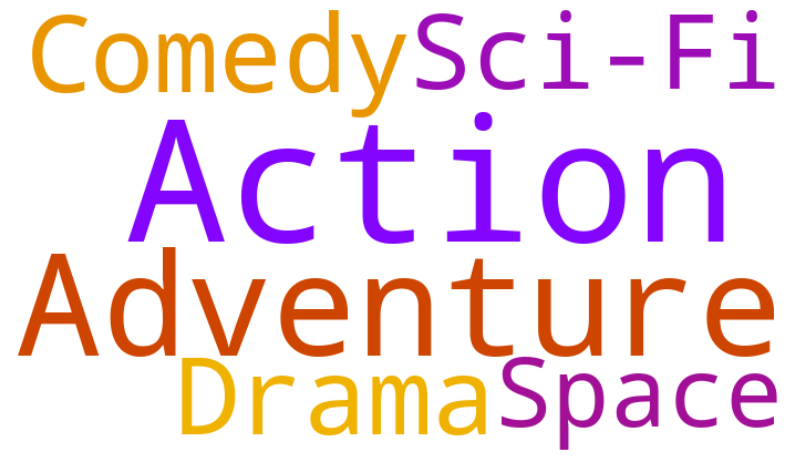

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [68]:
get_FavGenre(x, plot = True)

In [69]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        get_FavGenre(anime_df_rows,plot)


    return anime_df_rows

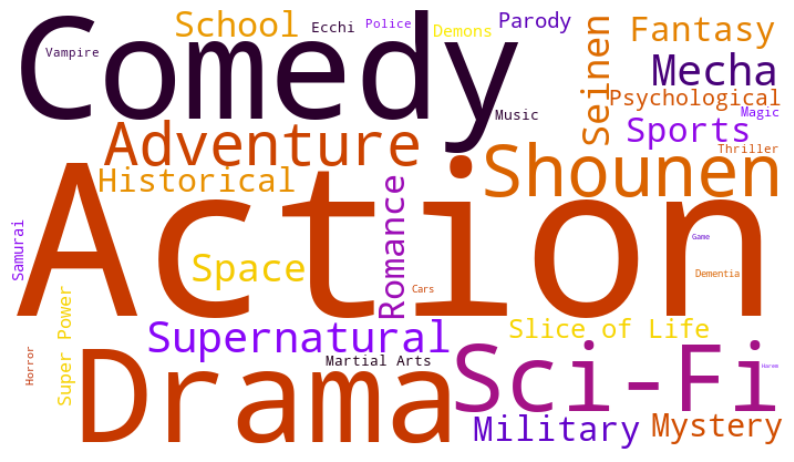

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [70]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [71]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n = 10):
    
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]  # Not recommend animes that the user have watched 

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)    
        
        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]  # How many similar users give this anime high rating

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name,df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),synopsis_df)

                recommended_animes.append({
                    "n" : n_user_pref,
                    "anime_name" : anime_name,
                    "Genres" : genre,
                    "Synopsis": synopsis
                })
                
    return pd.DataFrame(recommended_animes).head(n)

In [73]:
user_pref

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [72]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=3)

,n,anime_name,Genres,Synopsis
0,7,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
1,7,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2,7,Noragami Aragoto,"Action, Adventure, Comedy, Supernatural, Shounen","Yato and Yukine have finally mended their relationship as god and Regalia, and everyone has returned to their daily life. Yato remains a minor and unknown deity who continues taking odd jobs for five yen apiece in the hopes of one day having millions of worshippers and his own grand shrine. Hiyori Iki has yet to have her loose soul fixed by Yato, but she enjoys life and prepares to attend high school nonetheless. Taking place immediately after the first season, Noragami Aragoto delves into the complicated past between Yato and the god of war Bishamon. The female god holds a mysterious grudge against Yato, which often results in violent clashes between them. It doesn't help that Bishamon's most trusted and beloved Regalia, Kazuma, appears to be indebted to Yato. When lives are on the line, unraveling these mysteries and others may be the only way to correct past mistakes."


# **Hybrid Recommendation System**

In [ ]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ### An anime list based on preference of similar users
    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)



    ### A longer list adding similar animes (based on content embedding) to the animes in user-based list, 
    content_recommended_animes = []
    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")


    ###  Animes in the list are assigned their weight
    combined_scores = {}
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight 

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [77]:
check = {}
a = 'a'
print(check.get(a, 0))

check[a] = 0.5
print(check.get(a, 0))

0
0.5


In [78]:

hybrid_recommendation(user_id = 11880)


['Steins;Gate', 'Death Note', 'Noragami Aragoto', 'Noragami:Stray God', 'Spirited Away', 'Hotarubi no Mori e', 'Toradora!', 'Demon Slayer:Kimetsu no Yaiba', "Howl's Moving Castle", 'Attack on Titan']
Anime closest to Steins;Gate
Anime closest to Death Note
Anime closest to Noragami Aragoto
Anime closest to Noragami:Stray God
Anime closest to Spirited Away
Anime closest to Hotarubi no Mori e
Anime closest to Toradora!
Anime closest to Demon Slayer:Kimetsu no Yaiba
Anime closest to Howl's Moving Castle
Anime closest to Attack on Titan


['Steins;Gate',
 'Death Note',
 'Noragami Aragoto',
 'Noragami:Stray God',
 'Spirited Away',
 'Hotarubi no Mori e',
 'Toradora!',
 'Demon Slayer:Kimetsu no Yaiba',
 "Howl's Moving Castle",
 'Attack on Titan']